### PH464/564: Scientific Computing II
***J.S. Hazboun***
#### Katelyn Ebert
___

# Midterm Project

For this project we will use the [Gaia DR3 data release](https://gea.esac.esa.int/archive/) to explore the solar neighborhood. This is the same selection of data we've explored recently, which can be pulled from the Gaia data archive with the following query:

```sql
SELECT TOP 300000 phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp, parallax FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10
AND parallax > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
```

The data is also in the `data/` directory of this repository.

Using a subset of this data, we're going to focus on constructing models and inferring the parameters of those models using `NumPyro`.

## Data Down-Selection

To avoid lengthy run times we'll focus on only the nearby data.  Select out the objects with parallax > 40 milliarcseconds.


# Part I

For this part we'll remove (crudely) the white dwarf population (the dim secondary population of stars).  To do this we'll use a simple linear boundary to divide the population:

```python
x1, y1 = 0, 8
x2, y2 = 3, 16.5
m_div = (y2 - y1)/(x2 - x1)
b_div = y1 - m_div * x1
```
    where we'll be focusing on the objects with $M_G < m_\mathrm{div} (BP-RP) + b_\mathrm{div}$.
---

In [1]:
# All the imports!
import numpy as np 
from numpy import genfromtxt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
import math
import seaborn as sns


import jax
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

import pandas as pd

import arviz as az

In [ ]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [2]:
# Repeat initial steps from HW 4
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [ ]:
x1, y1 = 0, 8
x2, y2 = 3, 16.5
m_ms = (y2 - y1)/(x2 - x1)
b_ms = y1 - m_ms * x1

In [ ]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]
dwarf_sel = df.mg > m_ms*df['bp_rp'] + b_ms # updated, line slicing to remove white dwarfs
dwarfless_df = df[~(dwarf_sel) & nearby_sel] 

In [ ]:
plt.scatter(dwarfless_df.bp_rp, dwarfless_df.mg, s=1, alpha=0.5, color='g')
plt.title(r'Main Sequence Stars with $\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")
plt.show()

1. Construct a `NumPyro` model that models the population as a line, assuming $M_G$ to be distributed normally about this line with a standard deviation to be inferred from the data.  Perform an MCMC.


In [ ]:
def linear_model(x=None, y=None, σ_y=None):
    # priors
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 50))
    σ_y=numpyro.sample('sigma',dist.Uniform(0,10))

    # define the mean of the normal distribution
    μ = m * x + b

    # Likelihood
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(μ, σ_y), obs=y)

In [ ]:
type(dwarfless_df.bp_rp.values)

In [ ]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=dwarfless_df.bp_rp.values,
         y=dwarfless_df.mg.values)
mcmc.print_summary()

In [ ]:
samples = mcmc.get_samples()
print(samples)
az.plot_trace(mcmc);

Previous values (from HW5)
### b = 2.58
### m = 2.94
### sigma = 0.565
Current values:
### b = 2.59
### m = 2.94
### sigma = 0.57


    A. Discuss the differences between the prior distributions you choose for your model parameters and the marginal (i.e., one-dimensional) posterior distributions estimated with your MCMC.  Did you choose suitably uninformed priors?
    
We can note that our marginal posteriors lie within the range of values for our priors. (Intercept was 2.59 which lies within 0 - 10, Slope was 2.94 which lies within 0 - 5, scatter was 0.57 which lies within 0 - 10) Further, because our priors are uniform, we can also check that the posteriors aren't "railing" against our priors (aka, not forming a peak in the posteriors, but rather trying to reach a peak that lies beyond the possibilities). This doesn't appear to be the case: our peaks are nicely formed in the posteriors.

    B. Plot the models corresponding to 50 randomly chosen posterior samples from your MCMC.  Discuss the quality of the fit, and in particular the role that the standard deviation parameter is playing in this fit.

In [ ]:
# for simplicity, this will be our call for plotting the true data points
def plot_data():
    plt.scatter(dwarfless_df.bp_rp.values, dwarfless_df.mg.values,alpha=0.5, label='data')
    plt.xlabel('bp_rp')
    plt.ylabel('mg')

In [ ]:
# now let's plot our results over the top
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100) # define discrete x values to plot our function over


for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['m'][i] * x + samples['b'][i] # y = mx + b
    plt.plot(x, mu, color='orange', alpha=0.01);

As before, minimal scatter of our best-fit line. Our 50 samples form what appears to the eye to be just one line. The standard deviation parameter allows us to get this good of a fit since our real data has a genuine scatter about the line. If we ignored the scatter, our mcmc may have a harder time minimizing the deviation from the line. Further, including the standard deviation allows us to recreate our data and predict future data easily. We can see this with posterior prediction plots:

In [ ]:
post_pred_samples = infer.Predictive(linear_model, samples)(
    random.PRNGKey(0), x=dwarfless_df.bp_rp.values, σ_y=dwarfless_df.mg
)
post_pred_y = post_pred_samples["y"]
post_pred_y.shape

In [ ]:
plot_data()

label = "posterior predictive distribution"
for i in random.choice(rng_key, len(post_pred_y), (1,)):  # (1,) is the number of realizations
    plt.plot(dwarfless_df.bp_rp, post_pred_y[i], ".", color="purple", alpha=0.1, label=label)
    label = 'Posterior Prediction'
plt.legend(loc="lower right");

Note that we need only one realization to cover almost all of our real data points. Hence, this seems to be a really good model. The data in the bottom left corner and top right is hard to cover, so next we will construct a quadratic best-fit line to see if we can improve upon our model!

2. Construct a new model that models the relation between $(BP-RP)$ and $M_G$ quadratically.  Carefully choose priors; be sure to explore choices for locations and scales that are appropriate for the new parameters.  Run an MCMC.

My intuition is that our model reflects something close to a square root relationship, passing through an intercept nearly zero or slightly negative. However, for just a regular order 2 polynomial, we'll probably have a negative linear or negative quadratic term. So I'm going to choose $\theta_0$ = -5 to 5 for our intercept, and $\theta_1$ = -10 to 10 for the linear coeff, and $\theta_2$ = -10 to 10 for the quadratic coeff. Let's work with guassian priors, since I'm less confident that we have a hard cut-off with these ranges.

In [ ]:
# For ease, let's convert the columns of our pandas dataframe to numpy arrays
xdata = dwarfless_df.bp_rp.values
ydata = dwarfless_df.mg.values
print(type(xdata))

In [ ]:
def quad_model(xdata=None, ydata=None):
    # priors
    a = numpyro.sample('a', dist.Normal(loc=0,scale=10)) # intercept
    b = numpyro.sample('b', dist.Normal(loc=0,scale=20)) # linear coeff
    c = numpyro.sample('c', dist.Normal(loc=0,scale=20)) # quadratic coeff

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20)) # scatter coeff

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*xdata**2 + b*xdata + c) #this line is defining a quadratic with our priors for the coeffs

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(xdata)):
        obs = numpyro.sample('mg', dist.Normal(loc=μ, scale=σ), obs=ydata)

In [ ]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(quad_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         xdata=xdata,
         ydata=ydata)
mcmc.print_summary()

In [ ]:
az.plot_trace(mcmc, var_names=["~μ"]);

### A. Discuss the differences between the prior distributions you choose for your model parameters and the marginal (i.e., one-dimensional) posterior distributions estimated with your MCMC.  Did you choose suitably uninformed priors?

All of my marginal posteriors lie within the range of my priors, indicating that my priors are sufficientyly "un-informed". Further, our scatter remains fairly similar to before (0.45 vs 0.57), which we would expect, since the previous scatter was a close match. Next, we'll see if our posterior parameters are a good fit.

### B. Plot the model corresponding to 50 randomly chosen posterior samples from your MCMC.  Discuss the quality of the fit.

In [ ]:
samples = mcmc.get_samples()
#print(samples)

In [ ]:
# now let's plot our results over the top
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100) # define discrete x values to plot our function over


for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['a'][i] * x**2 + samples['b'][i] * x + samples['c'][i] # y = ax^2 + bx + c
    plt.plot(x, mu, color='orange', alpha=0.1);

This fit is even better than the linear fit! As we hoped. The best-fit stays within the spread of the data along the entire graph this time. We still have some possible outliers, but the level of match here is impressive! Let's confirm with a posterior-predictive plot. 

### C. **Graduate students:** Use your posterior estimates to predict the distribution we would expect for $M_G$ values of main sequence stars with color $(BP-RP) = 6$.

In [ ]:
# let's make sure our posterior predictive plot lines up well with our data
post_pred_samples = infer.Predictive(quad_model, samples)(
    random.PRNGKey(0), xdata=dwarfless_df.bp_rp.values)
post_pred_y = post_pred_samples["mg"]
post_pred_y.shape

In [ ]:
plot_data()

label = "posterior predictive distribution"
for i in random.choice(rng_key, len(post_pred_y), (10,)):  # (1,) is the number of realizations
    plt.scatter(dwarfless_df.bp_rp, post_pred_y[i], marker=".", color="purple", alpha=0.1)
plt.legend(loc="lower right");

Super cool, good match. Now, we want to expand our x-axis and make predictions for data we don't currently have

In [ ]:
# we want to expand our predictive model to sequence stars beyond what we've modeled, with xvalue at 6
xexpanded = np.arange(0,10,1)
post_pred_samples = infer.Predictive(quad_model, samples)(
    random.PRNGKey(0), xdata=xexpanded)
post_pred_y = post_pred_samples["mg"]
post_pred_y.shape

In [ ]:
plt.scatter(dwarfless_df.bp_rp.values, dwarfless_df.mg.values,alpha=0.5, label='data')

for i in random.choice(rng_key, len(post_pred_y), (10,)):  # (1,) is the number of realizations
    plt.scatter(xexpanded, post_pred_y[i], marker=".", color="purple")
plt.axhline(np.mean(post_pred_y[:,6]),color='grey',label='bp_rp = 6')
plt.axvline(6,color='grey')
plt.legend()
plt.show()

In [ ]:
# Now we can plot the histogram for many realizations to get a good sense of the mg for bp_rp =6
plt.hist(post_pred_y[:,6])
plt.title("Posterior Prediction for Main Sequence Star")
plt.xlabel('mg value')
plt.show()

To get a single value, we'll just grab the 6th' column and take the average

In [ ]:
mean = np.mean(post_pred_y[:,6])
print("The most likely mg value is", round(mean,1), "which matches our graph!")

3. **Graduate students:** Explore higher order polynomials a bit.  How does the (qualitative) quality of the fit behave?

Alrighty, let's try a 3rd order polynomial. I'm expecting that we may begin to overfit our data, which may show up in our posterior predictions beyond the range of data we're modelling, especially as the order of our polynomial grows.

In [ ]:
def cubic_model(xdata=None, ydata=None):
    # priors
    a = numpyro.sample('a', dist.Normal(loc=0,scale=10)) # intercept
    b = numpyro.sample('b', dist.Normal(loc=0,scale=20)) # linear coeff
    c = numpyro.sample('c', dist.Normal(loc=0,scale=20)) # quadratic coeff
    d = numpyro.sample('d', dist.Normal(loc=0,scale=20)) # cubic coeff, gonna leave the rest out of order so it's easier to compare

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20)) # scatter coeff

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  d*xdata**3+ a*xdata**2 + b*xdata + c) # y = dx^3 + ax^2 + bx +c

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(xdata)):
        obs = numpyro.sample('mg', dist.Normal(loc=μ, scale=σ), obs=ydata)

In [ ]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(cubic_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         xdata=xdata,
         ydata=ydata)
mcmc.print_summary()

Once again, our posteriors lie within the range of our priors. So our priors are reasonably uninformed

In [ ]:
samples = mcmc.get_samples()
az.plot_trace(mcmc, var_names=["~μ"]);

In [ ]:
# now let's plot our results over the top
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100) # define discrete x values to plot our function over


for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['d'][i] * x**3 + samples['a'][i] * x**2 + samples['b'][i] *x + samples['c'][i] # y = mx + b
    plt.plot(x, mu, color='pink', alpha=0.1);

So, a fairly comparable fit, indicating that adding more parameters at this point isn't making a difference at this point. Our data was already sufficiently modelled. 

In [ ]:
# we want to expand our predictive model to sequence stars beyond what we've modeled, with xvalue at 6
xexpanded = np.arange(0,10,1)
post_pred_samples = infer.Predictive(cubic_model, samples)(
    random.PRNGKey(0), xdata=xexpanded)
post_pred_y = post_pred_samples["mg"]
post_pred_y.shape

In [ ]:
plt.scatter(dwarfless_df.bp_rp.values, dwarfless_df.mg.values,alpha=0.5, label='data')

for i in random.choice(rng_key, len(post_pred_y), (10,)):  # (1,) is the number of realizations
    plt.scatter(xexpanded, post_pred_y[i], marker=".", color="purple")
plt.axhline(np.mean(post_pred_y[:,6]),color='grey',label='bp_rp = 6')
plt.axvline(6,color='grey')
plt.legend()
plt.show()

As I feared, our predictive values begin dipping down significantly as we extend our x-axis. This doesn't seem to match reality, indicating that we've begun to overfit.

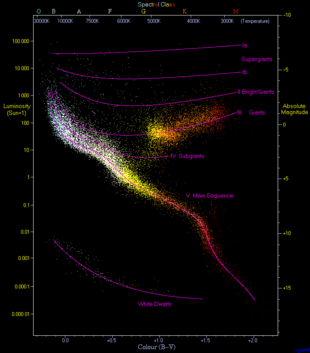

# Part II

Now let's bring the white dwarfs back into the mix, focusing on all the objects with parallax > 40 milliarcseconds.

1. Construct a mixture model with `NumPyro` that simultaneously describes the main sequence stars and white dwarfs, each described by a linear relationship with its own slope, y-intercept, and scatter of observations about it.

    **Tips:**
    1. Recall our outlier model we built, which outlines the machinery for building a mixture model that allows for our data to be described by more than one distribution.
    1. Our model will now be composed of two lines.  If we impose the same priors for the parameters of each line, then the two lines will be degenerate and sampling gets unnecessarily tricky.  There are many ways we could avoid this degeneracy, but for now I suggest imposing unique priors on the y-intercepts.  I also recommend a relatively narrow prior on the slopes of the lines to get the model from trying crazy solutions:
        ```python
        m_ms = numpyro.sample('m_ms', dist.Uniform(2, 5))
        b_ms = numpyro.sample('b_ms', dist.Uniform(0, 5))

        m_wd = numpyro.sample('m_wd', dist.Uniform(2, 5))
        b_wd = numpyro.sample('b_wd', dist.Uniform(10, 15))
        ```


In [3]:
# Since we're including our white dwarfs again, we'll need to update our data
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]

x = df[nearby_sel].bp_rp.values
y = df[nearby_sel].mg.values

In [ ]:
def linear_model_w_outliers(x=None, y=None):
    # First let's construct our foreground (main sequence) linear model
    m_ms = numpyro.sample('m_ms', dist.Uniform(2, 5))
    b_ms = numpyro.sample('b_ms', dist.Uniform(0, 5))
    σ_ms = numpyro.sample('σ_ms', dist.HalfNormal(scale=5))
    μ_fg = m_ms * x + b_ms
    dist_fg = dist.Normal(μ_fg, σ_ms)

    # Now lets define a model for the background (white dwarfs) linear  model
    m_wd = numpyro.sample('m_wd', dist.Uniform(2, 5))
    b_wd = numpyro.sample('b_wd', dist.Uniform(10, 15))
    σ_wd = numpyro.sample('σ_wd', dist.HalfNormal(scale=5))
    μ_wd = m_wd * x + b_wd
    dist_bg = dist.Normal(μ_wd, σ_wd)

    # We're going to assign each observation probabilistically to fg or bg using Categorical parameters
    P_fg = numpyro.sample('P_fg', dist.Uniform(0, 1)) # Prob an observation will be in the foreground

    # Define the foreground/background parameters, with equal probability between categories
    mixing_dist = dist.Categorical(probs=jnp.array([P_fg, 1 - P_fg]))
    mixture = dist.MixtureGeneral(mixing_dist, [dist_fg, dist_bg])

    # Likelihood
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [ ]:
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model_w_outliers)
num_samples = 4000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=x,
         y=y
         )
mcmc.print_summary()

In [ ]:
samples = mcmc.get_samples()
print(samples)
# so my kernel kept dying, so we'll need to filter out all of the parameters except the ones we care about
az.plot_trace(mcmc,var_names=['~log_p_fg*'],filter_vars='regex')

Here are the plots in case the Kernel is grumpy...
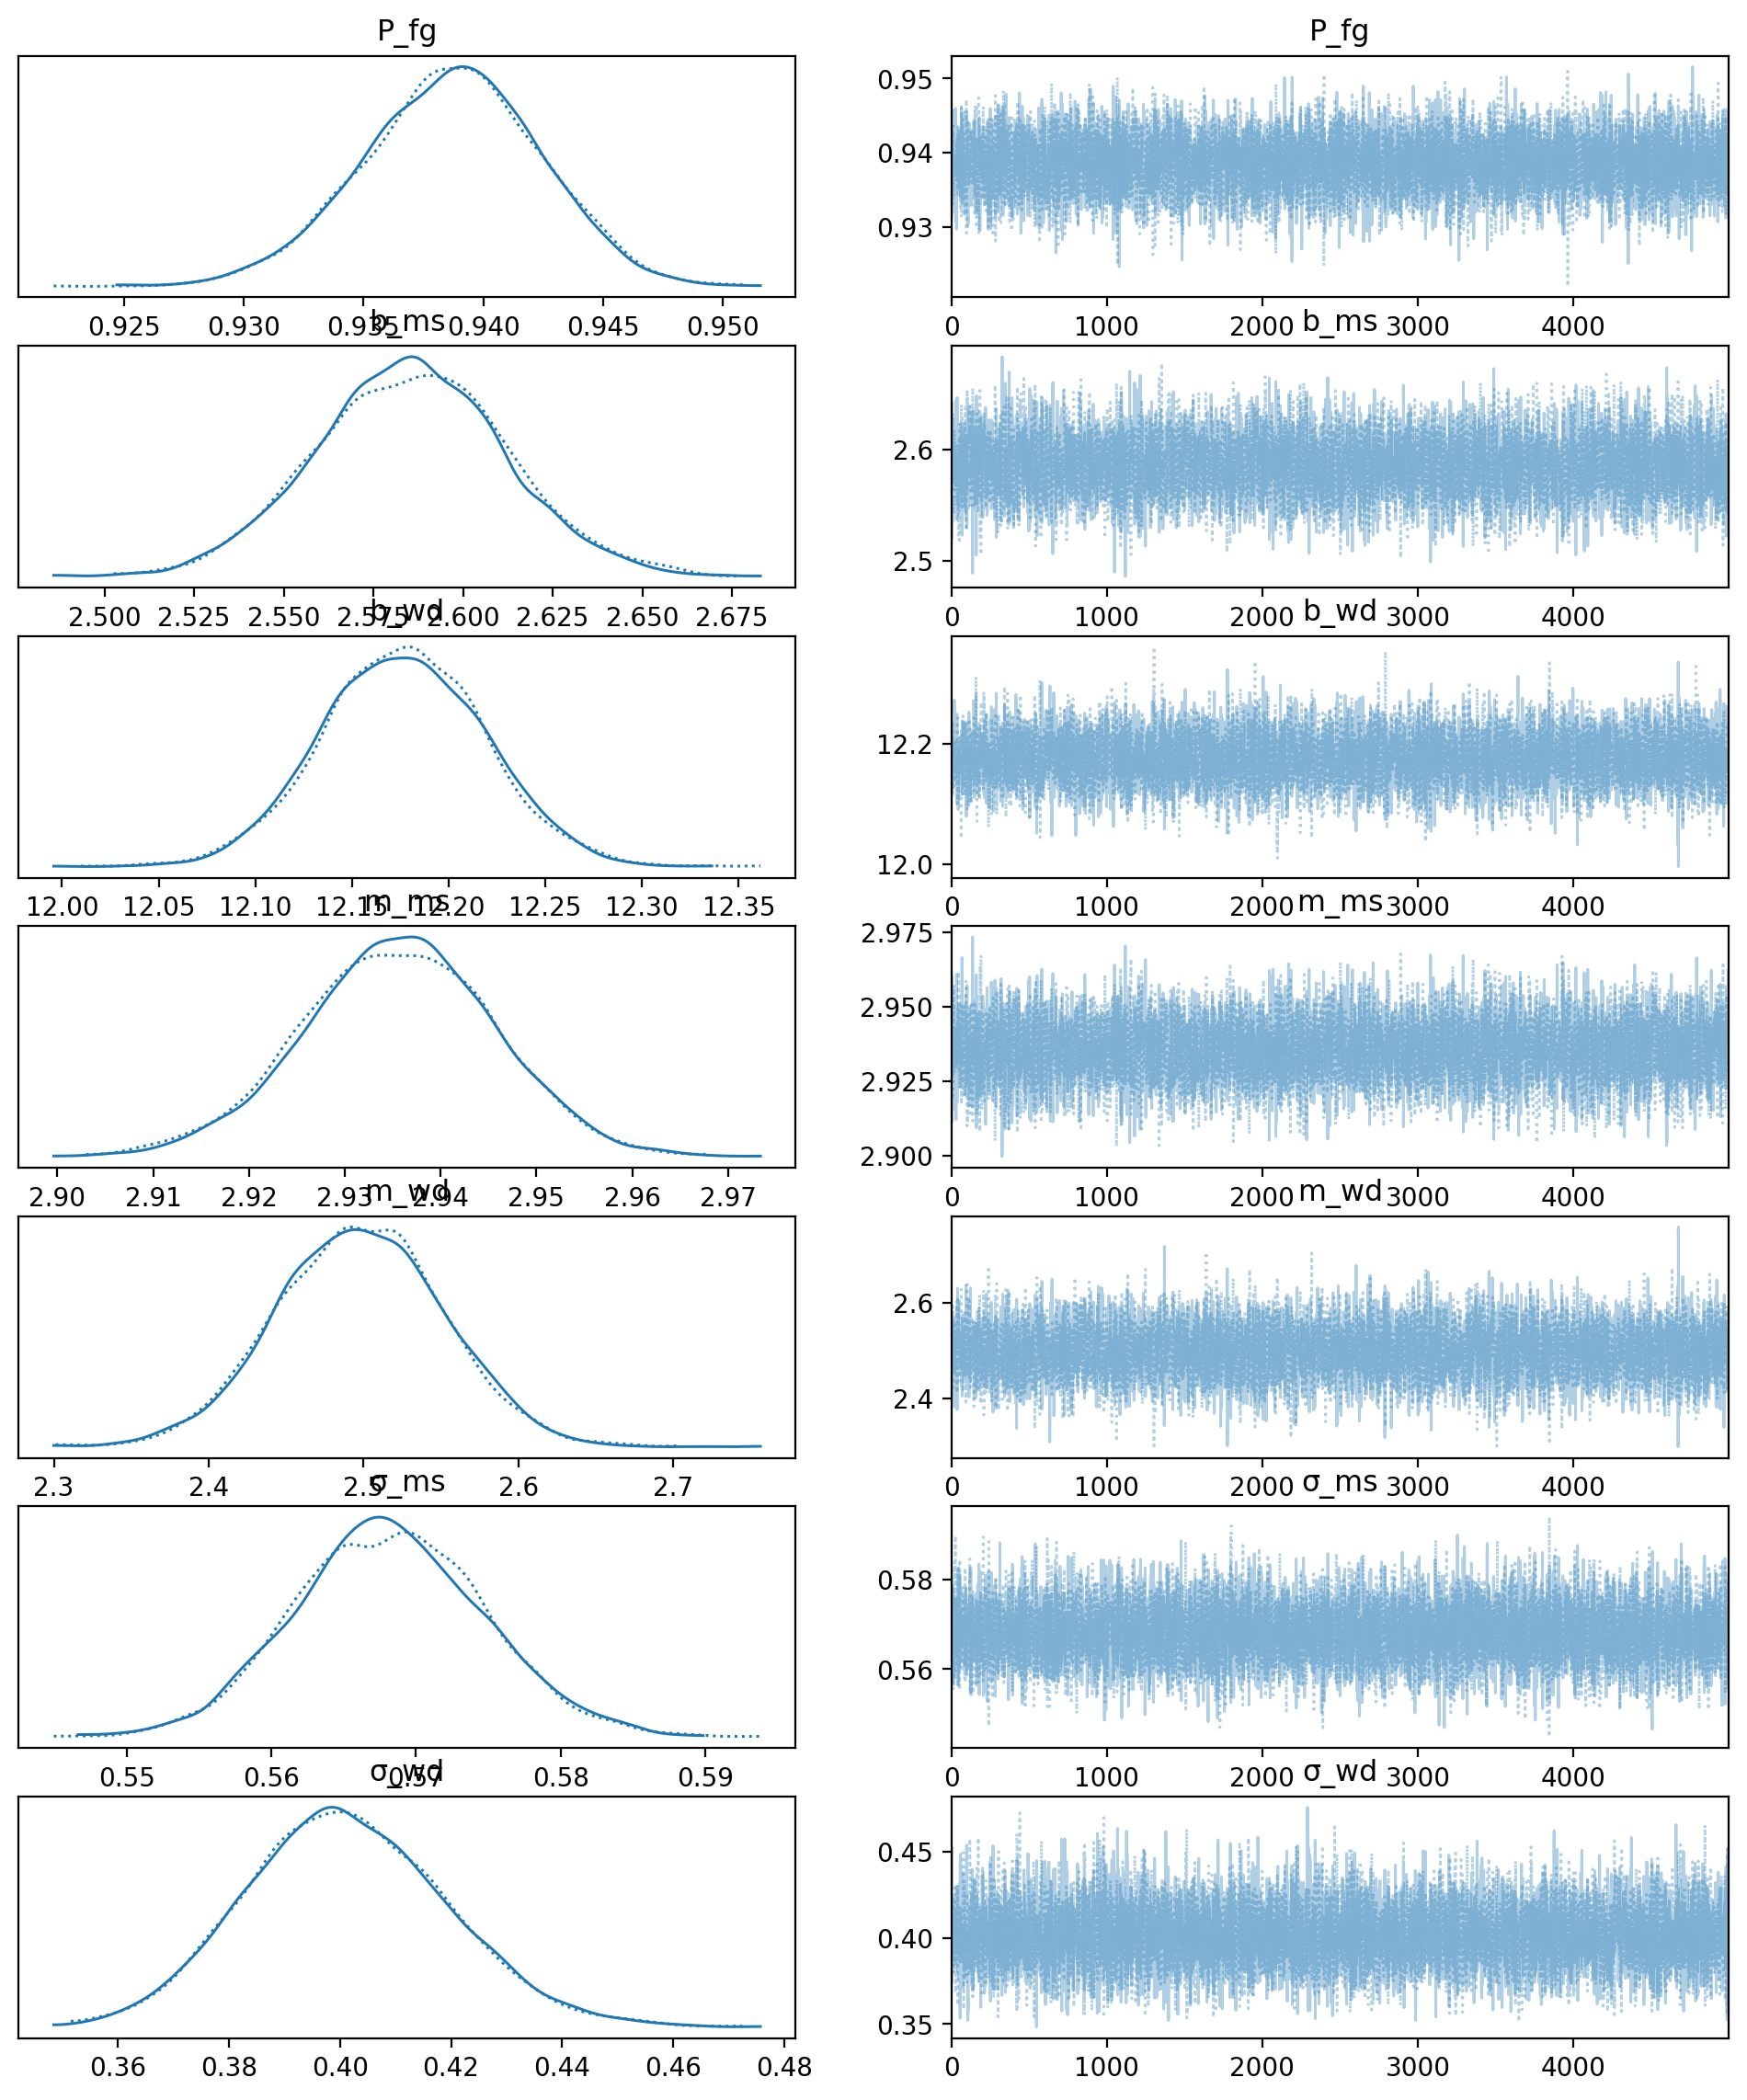

2. Plot the two lines for each of 50 randomly chosen posterior samples from your MCMC.  Discuss the quality of the fits, and in particular the constraints.  Is the model able to identify the two populations?

In [ ]:
print(len(samples["log_p_fg"]))

In [ ]:
p_fg = jnp.mean(jnp.exp(samples["log_p_fg"][..., 0]), axis=0)

In [ ]:
# We also need to incorporate white dwarfs into a plotting function.
def plot_full_data():
    plt.scatter(df.bp_rp.values, df.mg.values,alpha=0.5, label='data')
    plt.xlabel('bp_rp')
    plt.ylabel('mg')

In [ ]:
plot_full_data()

for i in random.choice(rng_key, num_samples, (50,)):
    mu_ms = samples['m_ms'][i] * x + samples['b_ms'][i]
    plt.plot(x, mu_ms, color='k', alpha=0.1)
    mu_wd = samples['m_wd'][i] * x + samples['b_wd'][i]
    plt.plot(x, mu_wd, color='green', alpha=0.1)
plt.plot(x, mu_ms, color='k', alpha=0.1, label='Main Sequence')
plt.plot(x, mu_wd, color='green', alpha=0.1, label='White dwarfs')

plt.scatter(x, y, marker="s", s=10, c=1 - p_fg, zorder=99, edgecolor="k", cmap="inferno")
plt.colorbar(label="outlier probability")
plt.legend()
plt.show()

Yes! I'd say the model is able to identify the two populations. The outlier probability for the white dwarf population is essentially 1, whereas the outlier probability is essentially zero for main sequence stars. Further, our posteriors are well constrained: they lie within the range of the priors for each parameter, they provide well-fitted posteriors (the best lines go through the data for each sequence), and none of the parameters diverge. 

3. **Graduate students:**
    A. Plot a distribution of the probabilities that each star in our catalog is on the main sequence.  Are there any stars which aren't confidently associated with a particular population?
    B. Relax the priors on slope and y-intercept and run an MCMC:
    ```python
    m_ms = numpyro.sample('m_ms', dist.Normal(scale=10))
    b_ms = numpyro.sample('b_ms', dist.Normal(scale=20))

    m_wd = numpyro.sample('m_wd', dist.Normal(scale=10))
    b_wd = numpyro.sample('b_wd', dist.Normal(scale=20))
    ```
    Take a look at the trace plots and the fits to the data.  Can you describe what's happening?

In [ ]:
plt.hist(p_fg[0:10],color='teal',alpha=0.5)
plt.hist(1-p_fg[0:10],color='purple',alpha=0.5)

This first part was just done on the plot above in further depth, but this confirms that the stars are either main sequence or white dwarfs. So, there aren't any stars that could be in either population.

In [5]:
## Now, let's relax the priors:
def relaxed_linear_model(x=None, y=None):
    # First let's construct our foreground (main sequence) linear model
    m_ms = numpyro.sample('m_ms', dist.Normal(scale=10))
    b_ms = numpyro.sample('b_ms', dist.Normal(scale=20))
    σ_ms = numpyro.sample('σ_ms', dist.HalfNormal(scale=5))
    μ_fg = m_ms * x + b_ms
    dist_fg = dist.Normal(μ_fg, σ_ms)

    # Now lets define a model for the background (white dwarfs) linear  model
    m_wd = numpyro.sample('m_wd', dist.Normal(scale=10))
    b_wd = numpyro.sample('b_wd', dist.Normal(scale=20))
    σ_wd = numpyro.sample('σ_wd', dist.HalfNormal(scale=5))
    μ_wd = m_wd * x + b_wd
    dist_bg = dist.Normal(μ_wd, σ_wd)

    # We're going to assign each observation probabilistically to fg or bg using Categorical parameters
    P_fg = numpyro.sample('P_fg', dist.Uniform(0, 1)) # Prob an observation will be in the foreground

    # Define the foreground/background parameters, with equal probability between categories
    mixing_dist = dist.Categorical(probs=jnp.array([P_fg, 1 - P_fg]))
    mixture = dist.MixtureGeneral(mixing_dist, [dist_fg, dist_bg])

    # Likelihood
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [ ]:
## Run the mcmc again
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(relaxed_linear_model)
num_samples = 4000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=x,
         y=y
         )
mcmc.print_summary()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      P_fg      0.50      0.39      0.50      0.11      0.89      1.00     73.28
      b_ms      7.41      5.03      7.05      2.32     12.62      1.00     38.58
      b_wd      7.41      5.03      7.09      2.31     12.62      1.00     37.60
      m_ms      1.67      1.37      1.78      0.24      3.06      1.00     31.50
      m_wd      1.67      1.37      1.79      0.24      3.06      1.00     30.41
      σ_ms      1.46      1.02      1.20      0.43      2.59      1.01     11.39
      σ_wd      1.46      1.02      1.20      0.43      2.60      1.01     11.38

Number of divergences: 0


In [7]:
samples = mcmc.get_samples()

In [ ]:
p_fg = jnp.mean(jnp.exp(samples["log_p_fg"][..., 0]), axis=0) # find the probabilities for our samples

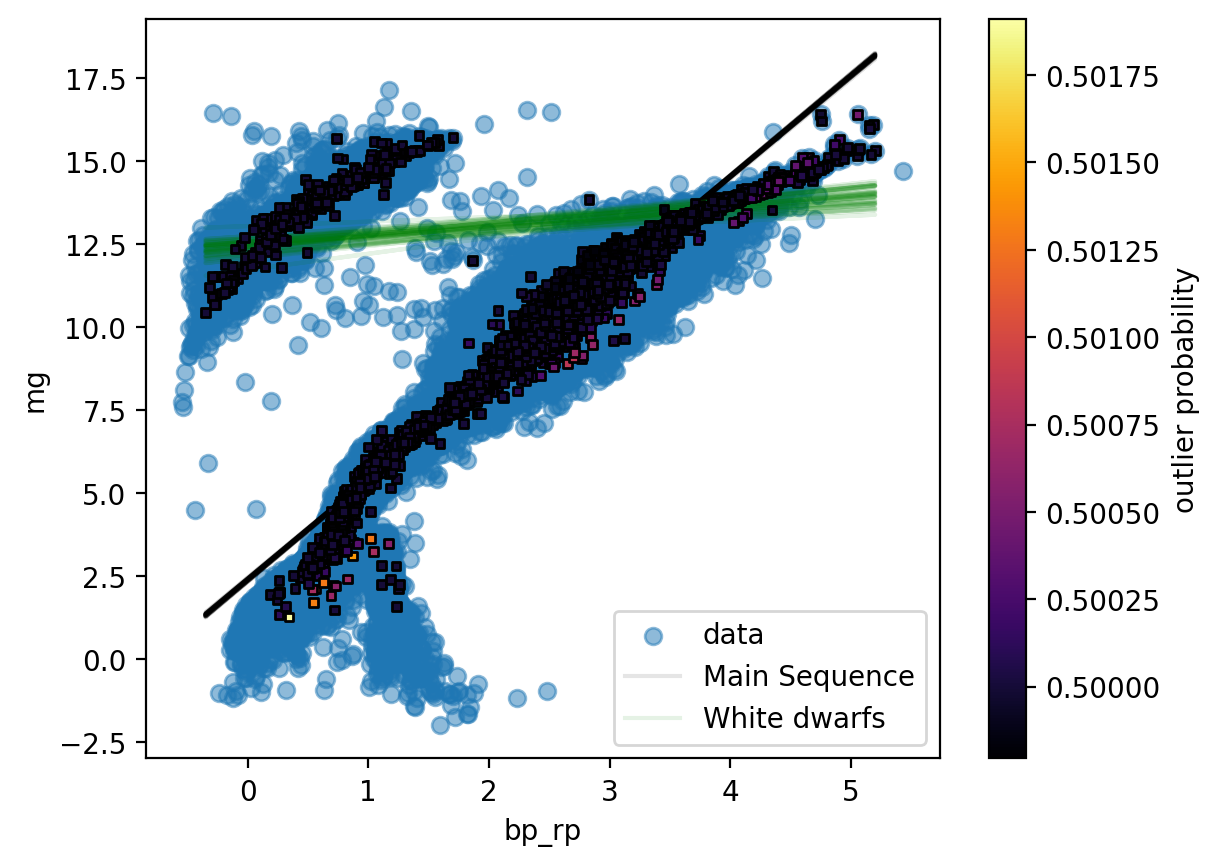

In [10]:
plot_full_data()

for i in random.choice(rng_key, num_samples, (50,)):
    mu_ms = samples['m_ms'][i] * x + samples['b_ms'][i]
    plt.plot(x, mu_ms, color='k', alpha=0.1)
    mu_wd = samples['m_wd'][i] * x + samples['b_wd'][i]
    plt.plot(x, mu_wd, color='green', alpha=0.1)
plt.plot(x, mu_ms, color='k', alpha=0.1, label='Main Sequence')
plt.plot(x, mu_wd, color='green', alpha=0.1, label='White dwarfs')

plt.scatter(x, y, marker="s", s=10, c=1 - p_fg, zorder=99, edgecolor="k", cmap="inferno")
plt.colorbar(label="outlier probability")
plt.legend()
plt.show()

With our relaxed priors, the mcmc is no longer able to identify the white dwarfs as outliers. Because of this, the best-fit line for the white dwarfs no longer provides a good match to the data, as it tries to connect the white dwarfs to the main sequence. Note also the scaling on our color map: most stars are black dots, which matches a 50% likelihood of being an outlier. 